In [3]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm

def find_image_dir():
    # Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
        # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"✅ Found images at: {IMAGE_DIR}")
else:
    # Fixed the broken string here to avoid SyntaxError
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")

# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name

# --- REMAINDER OF THE PIPELINE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Feature vector only

# If you have multiple GPUs (like T4 x2), this handles it
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
# Using 2 workers is usually safer on Kaggle to avoid memory overhead
loader = DataLoader(dataset, batch_size=128, num_workers=2, pin_memory=True)

features_dict = {}

with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        imgs = imgs.to(device)
        feats = model(imgs).view(imgs.size(0), -1)
        
        # Move back to CPU for storage in dictionary
        feats = feats.cpu().numpy()
        for i, name in enumerate(names):
            features_dict[name] = feats[i]

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"🚀 Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

✅ Found images at: /kaggle/input/d/adityajn105/flickr30k/Images
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s] 
Extracting Features: 100%|██████████| 249/249 [02:39<00:00,  1.56it/s]


🚀 Success! 31783 images processed and saved to flickr30k_features.pkl


**Inspect dataset structure**

In [4]:
import os

for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if 'caption' in file.lower():
            print(os.path.join(root, file))


/kaggle/input/d/adityajn105/flickr30k/captions.txt


**Load**

In [5]:
import pandas as pd

captions_path = '/kaggle/input/d/adityajn105/flickr30k/captions.txt'
captions_df = pd.read_csv(captions_path)

captions_df.head()


,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


**Captions Cleaning**

In [6]:
import string

def clean_caption(text):
    # Check if text is a string; if it's NaN (a float), return an empty string or 'none'
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    # Removes punctuation like ! @ # $ etc.
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Removes extra whitespace
    text = " ".join(text.split())
    return text

# Apply the fixed function
captions_df['caption'] = captions_df['caption'].apply(clean_caption)

# Check the results
print(captions_df.head())

            image                                            caption
0  1000092795.jpg  two young guys with shaggy hair look at their ...
1  1000092795.jpg  two young white males are outside near many bu...
2  1000092795.jpg     two men in green shirts are standing in a yard
3  1000092795.jpg         a man in a blue shirt standing in a garden
4  1000092795.jpg              two friends enjoy time spent together


**Add Special Tokens**

In [7]:
captions_df['caption'] = captions_df['caption'].apply(
    lambda x: '<start> ' + x + ' <end>'
)

**Count Word Frequencies**

In [8]:
from collections import Counter

all_captions = captions_df['caption'].tolist()

word_counter = Counter()

for caption in all_captions:
    word_counter.update(caption.split())

**Create Vocabulary Dictionary**
define special tokens manually first

In [9]:
all_captions = captions_df['caption'].tolist()

counter = Counter()

for caption in all_captions:
    counter.update(caption.split())

# Special tokens
vocab = {
    "<pad>": 0,
    "<start>": 1,
    "<end>": 2,
    "<unk>": 3
}

index = 4

for word, freq in counter.items():
    if word not in vocab:
        vocab[word] = index
        index += 1

# Reverse vocab
rev_vocab = {idx: word for word, idx in vocab.items()}

vocab_size = len(vocab)

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 20013


**Convert Captions to Sequences**

In [10]:
def caption_to_sequence(caption):
    return [vocab.get(word, vocab["<unk>"]) for word in caption.split()]

captions_df['sequence'] = captions_df['caption'].apply(caption_to_sequence)

**Compute Max Length Safely**

In [11]:
max_length = max(len(seq) for seq in captions_df['sequence'])
print("Max Caption Length:", max_length)

Max Caption Length: 80


**Pad Sequences Properly**

In [12]:
def pad_sequence(seq):
    if len(seq) > max_length:
        seq = seq[:max_length]
    return seq + [vocab["<pad>"]] * (max_length - len(seq))

captions_df['padded_sequence'] = captions_df['sequence'].apply(pad_sequence)

**Verify Shapes**

In [13]:
import torch

captions_tensor = torch.tensor(captions_df['padded_sequence'].tolist())

print("Captions Tensor Shape:", captions_tensor.shape)

Captions Tensor Shape: torch.Size([158915, 80])


**Save Vocabulary**

In [14]:
import pickle

with open("vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

with open("rev_vocab.pkl", "wb") as f:
    pickle.dump(rev_vocab, f)

**Load Image Features**

In [15]:
import pickle
import numpy as np

with open("flickr30k_features.pkl", "rb") as f:
    features_dict = pickle.load(f)

print("Total extracted image features:", len(features_dict))

Total extracted image features: 31783


**Match Captions with Image Features**

In [16]:
# Remove #0, #1 etc if present
captions_df['image_name'] = captions_df['image'].apply(lambda x: x.split('#')[0])

# Keep only rows where image feature exists
captions_df = captions_df[captions_df['image_name'].isin(features_dict.keys())]

print("Remaining samples:", len(captions_df))

Remaining samples: 158915


**Create Custom Dataset**

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader

class CaptionDataset(Dataset):
    def __init__(self, dataframe, features_dict):
        self.dataframe = dataframe.reset_index(drop=True)
        self.features_dict = features_dict
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        image_feature = torch.tensor(
            self.features_dict[row['image_name']],
            dtype=torch.float32
        )
        
        caption = torch.tensor(
            row['padded_sequence'],
            dtype=torch.long
        )
        
        return image_feature, caption

dataset = CaptionDataset(captions_df, features_dict)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

**Build Encoder**

In [18]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, feature_dim=2048, hidden_size=512):
        super(Encoder, self).__init__()
        self.linear = nn.Linear(feature_dim, hidden_size)
        self.relu = nn.ReLU()
        
    def forward(self, features):
        return self.relu(self.linear(features))

**Build Decoder**

In [19]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512):
        super(Decoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, captions, hidden):
        embeddings = self.embedding(captions)
        outputs, hidden = self.lstm(embeddings, hidden)
        outputs = self.fc(outputs)
        return outputs, hidden

**Combining Encoder and Decoder**

In [20]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size):
        super(ImageCaptioningModel, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder(vocab_size)
        
    def forward(self, features, captions):
        
        hidden_state = self.encoder(features)
        
        # LSTM expects (h0, c0)
        hidden = (
            hidden_state.unsqueeze(0),
            torch.zeros_like(hidden_state.unsqueeze(0))
        )
        
        outputs, _ = self.decoder(captions[:, :-1], hidden)
        
        return outputs

**Training**
Setup Training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImageCaptioningModel(vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Training Loop**

In [22]:
num_epochs = 5

train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for features, captions in dataloader:
        features = features.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features, captions)
        
        loss = criterion(
            outputs.reshape(-1, vocab_size),
            captions[:, 1:].reshape(-1)
        )
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5], Loss: 3.9365
Epoch [2/5], Loss: 3.1909
Epoch [3/5], Loss: 2.9069
Epoch [4/5], Loss: 2.7046
Epoch [5/5], Loss: 2.5412


**GREEDY SEARCH**

In [23]:
def generate_caption_greedy(model, feature, max_length=40):
    model.eval()
    
    feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
    
    hidden_state = model.encoder(feature)
    hidden = (
        hidden_state.unsqueeze(0),
        torch.zeros_like(hidden_state.unsqueeze(0))
    )
    
    input_word = torch.tensor([[vocab["<start>"]]]).to(device)
    
    generated = []
    
    for _ in range(max_length):
        embeddings = model.decoder.embedding(input_word)
        output, hidden = model.decoder.lstm(embeddings, hidden)
        output = model.decoder.fc(output.squeeze(1))
        
        predicted = output.argmax(1)
        word = rev_vocab[predicted.item()]
        
        if word == "<end>":
            break
            
        generated.append(word)
        input_word = predicted.unsqueeze(0)
        
    return " ".join(generated)

**BLEU SCORE**

In [24]:
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

def compute_bleu(reference, predicted):
    reference_tokens = reference.split()
    predicted_tokens = predicted.split()
    return sentence_bleu([reference_tokens], predicted_tokens)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**LOSS CURVE**

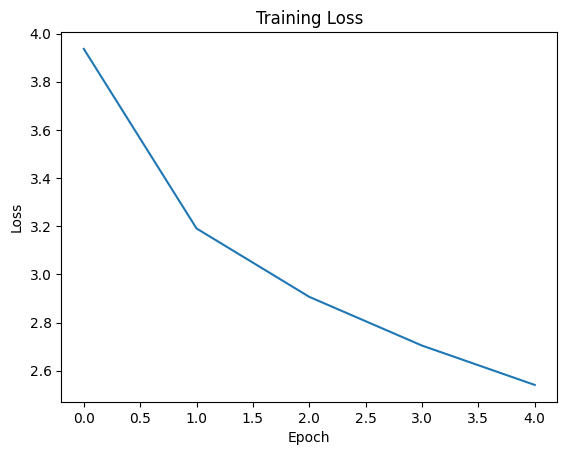

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

**TEST 5 RANDOM IMAGES**

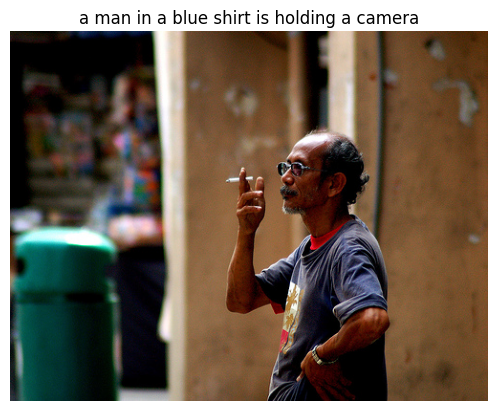

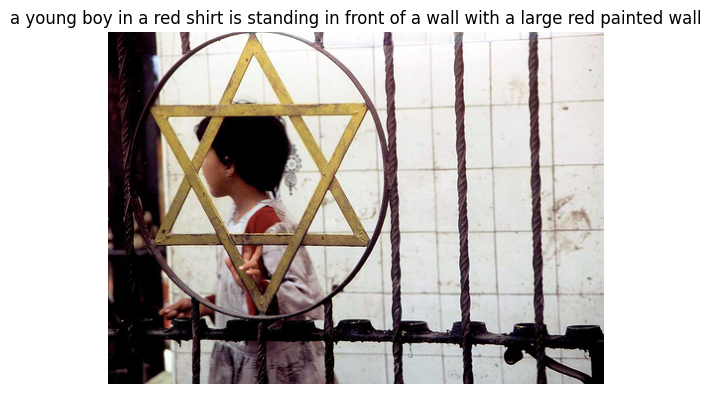

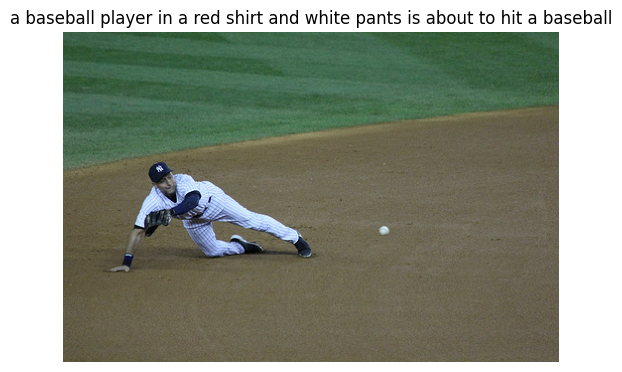

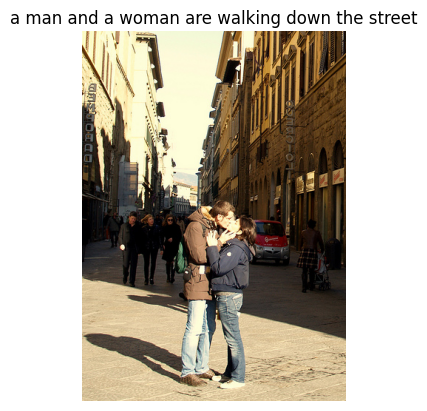

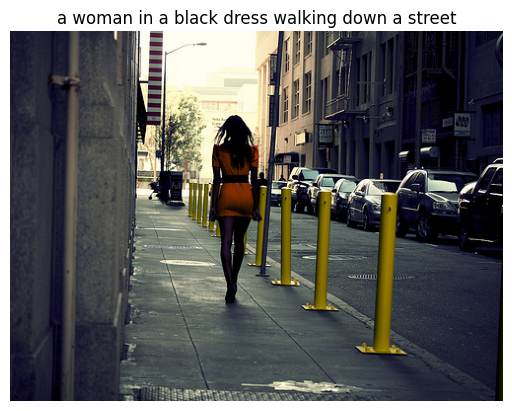

In [26]:
import random
import matplotlib.pyplot as plt
from PIL import Image

sample_images = random.sample(list(features_dict.keys()), 5)

for img_name in sample_images:
    
    img_path = f"{IMAGE_DIR}/{img_name}"
    image = Image.open(img_path)
    
    caption = generate_caption_greedy(model, features_dict[img_name])
    
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)
    plt.show()

**Proper Train / Validation Split**

In [27]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    captions_df,
    test_size=0.2,
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

Train size: 127132
Validation size: 31783


In [28]:
train_dataset = CaptionDataset(train_df, features_dict)
val_dataset = CaptionDataset(val_df, features_dict)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

**TRAINING LOOP WITH VALIDATION**

In [29]:
num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    
    # -------- TRAIN --------
    model.train()
    total_train_loss = 0
    
    for features, captions in train_loader:
        features = features.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features, captions)
        
        loss = criterion(
            outputs.reshape(-1, vocab_size),
            captions[:, 1:].reshape(-1)
        )
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # -------- VALIDATION --------
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for features, captions in val_loader:
            features = features.to(device)
            captions = captions.to(device)
            
            outputs = model(features, captions)
            
            loss = criterion(
                outputs.reshape(-1, vocab_size),
                captions[:, 1:].reshape(-1)
            )
            
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}")

Epoch 1
Train Loss: 2.4000
Val Loss: 2.4166
Epoch 2
Train Loss: 2.2738
Val Loss: 2.4490
Epoch 3
Train Loss: 2.1633
Val Loss: 2.4880
Epoch 4
Train Loss: 2.0657
Val Loss: 2.5259
Epoch 5
Train Loss: 1.9755
Val Loss: 2.5666


**BEAM SEARCH IMPLEMENTATION**

In [30]:
def generate_caption_beam(model, feature, beam_width=3, max_length=40):
    model.eval()
    
    feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
    
    hidden_state = model.encoder(feature)
    hidden = (
        hidden_state.unsqueeze(0),
        torch.zeros_like(hidden_state.unsqueeze(0))
    )
    
    sequences = [[ [vocab["<start>"]], 0.0, hidden ]]
    
    for _ in range(max_length):
        all_candidates = []
        
        for seq, score, hidden_state in sequences:
            
            input_word = torch.tensor([[seq[-1]]]).to(device)
            
            embeddings = model.decoder.embedding(input_word)
            output, new_hidden = model.decoder.lstm(embeddings, hidden_state)
            output = model.decoder.fc(output.squeeze(1))
            
            log_probs = torch.log_softmax(output, dim=1)
            top_log_probs, top_indices = torch.topk(log_probs, beam_width)
            
            for i in range(beam_width):
                word = top_indices[0][i].item()
                new_seq = seq + [word]
                new_score = score + top_log_probs[0][i].item()
                all_candidates.append([new_seq, new_score, new_hidden])
        
        ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        sequences = ordered[:beam_width]
    
    best_seq = sequences[0][0]
    
    caption = []
    for idx in best_seq:
        word = rev_vocab[idx]
        if word in ["<start>", "<end>", "<pad>"]:
            continue
        caption.append(word)
    
    return " ".join(caption)

**BLEU SCORE**

In [31]:
from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu(model, dataframe, num_samples=100):
    scores = []
    
    samples = dataframe.sample(num_samples)
    
    for _, row in samples.iterrows():
        image_name = row['image_name']
        reference = row['caption']
        
        prediction = generate_caption_greedy(
            model,
            features_dict[image_name]
        )
        
        score = sentence_bleu(
            [reference.split()],
            prediction.split()
        )
        
        scores.append(score)
    
    return sum(scores) / len(scores)

bleu_score = evaluate_bleu(model, val_df)
print("BLEU-4 Score:", bleu_score)

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU-4 Score: 0.012870229628574528


**PRECISION / RECALL / F1**: Token Level evaluation

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_token_metrics(model, dataframe, num_samples=100):
    
    y_true = []
    y_pred = []
    
    samples = dataframe.sample(num_samples)
    
    for _, row in samples.iterrows():
        image_name = row['image_name']
        reference = row['caption'].split()
        
        prediction = generate_caption_greedy(
            model,
            features_dict[image_name]
        ).split()
        
        min_len = min(len(reference), len(prediction))
        
        y_true.extend(reference[:min_len])
        y_pred.extend(prediction[:min_len])
    
    # Convert words to numbers
    y_true_ids = [vocab.get(w, vocab["<unk>"]) for w in y_true]
    y_pred_ids = [vocab.get(w, vocab["<unk>"]) for w in y_pred]
    
    precision = precision_score(y_true_ids, y_pred_ids, average='macro')
    recall = recall_score(y_true_ids, y_pred_ids, average='macro')
    f1 = f1_score(y_true_ids, y_pred_ids, average='macro')
    
    return precision, recall, f1

precision, recall, f1 = evaluate_token_metrics(model, val_df)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.005872672869676492
Recall: 0.007329520711732426
F1 Score: 0.005917882028439392


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
torch.save(model.state_dict(), "model.pth")


In [34]:
import torch
import pickle

# Save trained model
torch.save(model.state_dict(), "/kaggle/working/model.pth")

# Save vocabulary
with open("/kaggle/working/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

# Save reverse vocabulary
with open("/kaggle/working/rev_vocab.pkl", "wb") as f:
    pickle.dump(rev_vocab, f)

print("All files saved successfully!")

All files saved successfully!


In [35]:
import os
print(os.listdir("/kaggle/working"))


['flickr30k_features.pkl', 'model.pth', '.virtual_documents', 'rev_vocab.pkl', 'vocab.pkl']


**GRADIO**

In [37]:
!pip install gradio torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 12.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.8 MB/s eta 0:00:0000:01
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.5
    Uninstalling pydantic_core-2.41.5:
      Successfully uninstalled pydantic_core-2.41.5
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.5
    Uninstalling pydantic-2.12.5:
      Successfully uninstalled pydantic-2.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
langchain-core 0.3.79 requires packaging<26.0.0,>=23.2.0, but you have packaging 26.0rc2 which is incompatible.
fastai 2.8.4 requires fastcore

In [38]:
import gradio as gr
import torch
import pickle
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np

# ---------------- LOAD SAVED FILES ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load vocab
with open("/kaggle/working/vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

with open("/kaggle/working/rev_vocab.pkl", "rb") as f:
    rev_vocab = pickle.load(f)

vocab_size = len(vocab)

# Load model
model = ImageCaptioningModel(vocab_size).to(device)
model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location=device))
model.eval()

# ---------------- IMAGE FEATURE EXTRACTOR ----------------
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet = resnet.to(device)
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ---------------- CAPTION FUNCTION ----------------
def generate_caption_from_image(image):
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = resnet(image).cpu().numpy()[0]

    caption = generate_caption_greedy(model, features)
    return caption

# ---------------- GRADIO INTERFACE ----------------
gr.Interface(
    fn=generate_caption_from_image,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=gr.Textbox(label="Generated Caption"),
    title="Image Captioning using CNN-LSTM",
    description="Final Year Project – Image Caption Generation"
).launch()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s] 


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://7d3d232981abb6d29c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# 🚀 Live Deployment

The trained model is deployed using Gradio on HuggingFace Spaces.

Live App:
https://huggingface.co/spaces/syedghani/neural-storyteller